<a href="https://colab.research.google.com/github/nrohrbach/KeyFiguresElectricalInstallations/blob/main/KeyFiguresElectricalInstallations36kV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kennzahlen Geobasisdatensatz Elektrische Anlagen mit einer Nennspannung von über 36kV

---

Notebook um Kennzahlen des Geobasisdatensatzes "Elektrische Anlagen mit einer Nennspannung von über 36kV abzuleiten.


**Offene Fragen**

*   Sollen bei Leitungen die Erdungen auch gezählt werden oder nicht?
*   Hat Swissgrid auch Stationen der Netzebene 4?

**ToDo**

*   Kennzahlen Stationen nach Netzebene 2 und 4 unterteilen





In [ ]:
#pip install geopandas

In [ ]:
#pip install datetime

In [ ]:
pip install numpy

In [4]:
import geopandas as gpd
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [60]:
url = "https://data.geo.admin.ch/ch.bfe.elektrische-anlagen_ueber_36/gpkg/2056/ElektrischeAnlagenNennspannungUeber36kV_V1.gpkg"
dfLeitung = gpd.read_file(url, driver="GPKG", layer='ElektrischeAnlagenNennspannungUeber36kV_V1_ElektrischeAnlagen_Leitung')
dfStation = gpd.read_file(url, driver="GPKG", layer='ElektrischeAnlagenNennspannungUeber36kV_V1_ElektrischeAnlagen_Station')
dfMast = gpd.read_file(url, driver="GPKG", layer='ElektrischeAnlagenNennspannungUeber36kV_V1_ElektrischeAnlagen_Mast')

## Kennzahlen Leitungen

In [61]:
# Länge der Leitungen berechnen und nach Spannung aufsummieren
dfLeitung["Laenge"] = dfLeitung.length
dfLeitungKPI = dfLeitung.groupby(['StromnetzTyp','Spannung','LeitungTyp'])['Laenge'].sum()
dfLeitungKPI = dfLeitungKPI.to_frame().reset_index()
dfLeitungKPI['Datum'] = datetime.today().strftime("%Y-%m-%d")

In [62]:
#Speichern
dfLeitungKPI.to_csv("Kennzahlen_Leitungen.csv", header=False, index=False, mode='a')

## Kennzahlen Masten

In [63]:
dfMastKPI = dfMast.groupby(['StromnetzTyp','MastTyp'])['xtf_id'].count().reset_index()
dfMastKPI = dfMastKPI.rename(columns={'xtf_id':'Anzahl'})
dfMastKPI['Datum'] = datetime.today().strftime("%Y-%m-%d")

In [64]:
#Speichern
dfMastKPI.to_csv("Kennzahlen_Masten.csv", header=True, index=False, mode='a')

## Kennzahlen Stationen

In [65]:
dfStationKPI = dfStation.groupby(['StromnetzTyp','StationTyp'])['xtf_id'].count().reset_index()
dfStationKPI = dfStationKPI.rename(columns={'xtf_id':'Anzahl'})
dfStationKPI['Datum'] = datetime.today().strftime("%Y-%m-%d")

In [66]:
#Speichern
dfStationKPI.to_csv("Kennzahlen_Stationen.csv", header=True, index=False, mode='a')

## Kennzahlen Werke

In [67]:
# Leitungslänge pro Werk ableiten.
dfWerkeLeitung = dfLeitung.groupby(['Eigentuemer','LeitungTyp'])['Laenge'].sum()
dfWerkeLeitung = dfWerkeLeitung.to_frame().reset_index()
dfWerkeLeitung = pd.pivot(dfWerkeLeitung,index='Eigentuemer',columns='LeitungTyp')
dfWerkeLeitung = dfWerkeLeitung.reset_index()
dfWerkeLeitung.columns = dfWerkeLeitung.columns.droplevel()
dfWerkeLeitung.columns = ['Werk','Freileitung','Kabelleitung']
dfWerkeLeitung = dfWerkeLeitung.fillna(0)
dfWerkeLeitung['LeitungGesamt']= dfWerkeLeitung['Kabelleitung']+dfWerkeLeitung['Freileitung']

In [78]:
# Leitungslänge pro Werk ableiten.
#dfWerkeLeitung = dfLeitung
#dfWerkeLeitung['Werk'] = dfWerkeLeitung['xtf_id'].str.split('_').str[0]
#dfWerkeLeitung = dfWerkeLeitung.groupby(['Werk'])['Laenge'].sum()
#dfWerkeLeitung = dfWerkeLeitung.to_frame().reset_index()
#dfWerkeLeitung = dfWerkeLeitung.rename(columns={'Laenge':'LaengeLeitung'})

In [79]:
# Anzahl Masten pro Werk ableiten.
dfWerkeMast = dfMast
dfWerkeMast['Werk'] = dfWerkeMast['Eigentuemer']
dfWerkeMast = dfWerkeMast.groupby(['Werk'])['xtf_id'].count().reset_index()
dfWerkeMast = dfWerkeMast.rename(columns={'xtf_id':'AnzahlMasten'})

In [81]:
# Anzahl Stationen pro Werk ableiten.
dfWerkeStation = dfStation
dfWerkeStation['Werk'] = dfWerkeStation['Eigentuemer']
dfWerkeStation = dfWerkeStation.groupby(['Werk'])['xtf_id'].count().reset_index()
dfWerkeStation = dfWerkeStation.rename(columns={'xtf_id':'AnzahlStationen'})

In [82]:
# Zusammenführen
dfWerke = pd.merge(dfWerkeLeitung, dfWerkeMast, how="left", on=["Werk"])
dfWerke = pd.merge(dfWerke, dfWerkeStation, how="left", on=["Werk"])
dfWerke = dfWerke.fillna(0)
dfWerke['Datum'] = datetime.today().strftime("%Y-%m-%d")

In [86]:
#Speichern
dfWerke.to_csv("Kennzahlen_Werke.csv", header=True, index=False, mode='a')

## Kennzahlen für Visualisierung in Storymap ableiten

In [ ]:
dfLeitungStorymap = dfLeitungKPI

# Gewünschte Kategorien definieren
Bedingungen = [dfLeitungStorymap['Spannung']=='S380kV',
               dfLeitungStorymap['Spannung']=='S220kV',
               (dfLeitungStorymap['StromnetzTyp']=='Allgemeinstrom') & (dfLeitungStorymap['Spannung'].isin(['S150kV','S132kV','S130kV','S125kV','S110kV'])),
               (dfLeitungStorymap['StromnetzTyp']=='Allgemeinstrom') & (dfLeitungStorymap['Spannung'].isin(['S66kV','S65kV','S60kV','S50kV','S36kV','Andere'])),
               (dfLeitungStorymap['StromnetzTyp']=='Bahnstrom') & (dfLeitungStorymap['Spannung']=='S132kV'),
               (dfLeitungStorymap['StromnetzTyp']=='Bahnstrom') & (dfLeitungStorymap['Spannung'].isin(['S66kV','Andere']))
               ]

Spannungen = ['s380','s220','s150','s66','s132B','s66B']

# Neues Attribut "Kategorie" erstellen welches für alle Objekte die gewünschte Kategorie bestimmt
dfLeitungStorymap['Kategorie'] =  np.select(Bedingungen,Spannungen)

In [ ]:
# Dataframe für Totale Länge vorbereiten
dfTotal = dfLeitungStorymap.groupby('Kategorie').sum(numeric_only=True).reset_index()
dfTotal['Kategorie'] = 'Total_'+ dfTotal['Kategorie']
dfTotal = dfTotal.transpose()
dfTotal.columns = dfTotal.iloc[0]
dfTotal = dfTotal[1:]
dfTotal['Datum'] = datetime.today().strftime("%Y-%m-%d")

In [ ]:
# Dataframe für Länge von Kabel vorbereiten
dfKabel = dfLeitungStorymap.loc[dfLeitungStorymap['LeitungTyp']=='Kabelleitung'].groupby('Kategorie').sum(numeric_only=True).reset_index()
dfKabel['Kategorie'] = 'Kabel_'+ dfKabel['Kategorie']
dfKabel = dfKabel.transpose()
dfKabel.columns = dfKabel.iloc[0]
dfKabel = dfKabel[1:]
dfKabel['Datum'] = datetime.today().strftime("%Y-%m-%d")

In [ ]:
# Zusammenführen
dfStorymap = pd.merge(dfTotal, dfKabel, how='left', on=["Datum"])

In [ ]:
#Temporäre Platzhalter für die Bahnstromkategorien erstellen. kann später gelöscht werden!
dfStorymap['Total_s132B'] = 1
dfStorymap['Kabel_s132B'] = 1
dfStorymap['Total_s66B'] = 1
dfStorymap['Kabel_s66B'] = 1
dfStorymap

Kategorie,Total_s150,Total_s220,Total_s380,Total_s66,Datum,Kabel_s150,Kabel_s220,Kabel_s380,Kabel_s66,Total_s132B,Kabel_s132B,Total_s66B,Kabel_s66B
0,2349055.72573,4857296.789805,1915187.111824,4915281.230717,2023-05-03,894904.391234,25013.209003,22044.578551,742579.917095,1,1,1,1


In [85]:
#Speichern
dfStorymap.to_csv("Kennzahlen_Storymap.csv", header=True, index=False, mode='a')

NameError: ignored

In [88]:
import matplotlib.pyplot as plt

In [87]:
#Visualisierung
df = pd.read_csv("Kennzahlen_Werke.csv", parse_dates=['Datum'])
df

,Werk,Freileitung,Kabelleitung,LeitungGesamt,AnzahlMasten,AnzahlStationen,Datum
0,AEK,0.000000e+00,9.755083e+03,9.755083e+03,0.0,0.0,2023-06-20
1,Axpo Grid AG,1.823685e+06,4.182596e+05,2.241945e+06,7010.0,37.0,2023-06-20
2,IBC,1.045754e+04,3.599944e+04,4.645698e+04,25.0,4.0,2023-06-20
3,IWB,0.000000e+00,1.137061e+06,1.137061e+06,0.0,145.0,2023-06-20
4,SEG,1.568531e+04,7.663695e+03,2.334900e+04,339.0,3.0,2023-06-20
5,Swissgrid,1.050245e+07,8.555847e+04,1.058801e+07,11975.0,134.0,2023-06-20


In [110]:
df_all = df.pivot(index="Datum", columns=["Werk"], values=['AnzahlMasten'])
dfTest = df_all.melt(ignore_index=False).reset_index()
dfTest = dfTest.sort_values('value',ascending=False)

#dfm = df.melt(ignore_index=False).reset_index()
#dfTest.plot(figsize=(15,10))

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Swissgrid'),
  Text(1, 0, 'Axpo Grid AG'),
  Text(2, 0, 'SEG'),
  Text(3, 0, 'IBC'),
  Text(4, 0, 'AEK'),
  Text(5, 0, 'IWB')])

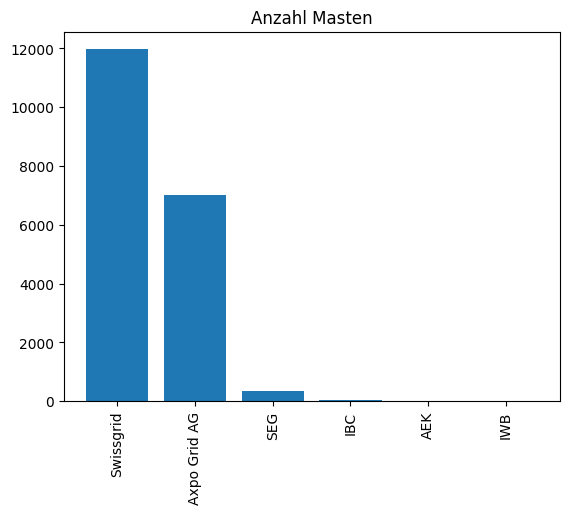

In [116]:
fig, ax = plt.subplots()
ax.bar(dfTest['Werk'], dfTest['value'])
ax.set_title('Anzahl Masten')
plt.xticks(rotation = 90)